In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import h5py
from pathlib import Path
from torch.utils import data
import logging
from datetime import datetime
from collections import Counter
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
import pandas as pd

In [2]:
# Wrapping the dataset with load function
class CustomDataset(data.Dataset):
    def __init__(self, file_path, transform=None):
        super().__init__()
        self.train_data_cache = []
        self.test_data_cache = []
        self.manual_data_cache = []
        self.full_test_data_cache = []
        self.transform = transform
        self.label_count = [0, 0, 0]
        # Search for all h5 files
        p = Path(file_path)
        files = p.glob('*.h5')
        logging.debug(files)
        for h5dataset_fp in files:
            logging.debug(h5dataset_fp)
            with h5py.File(h5dataset_fp.resolve()) as h5_file:
                # Walk through all groups, extracting datasets
                for gname, group in h5_file.items():
                    k = 0
                    j = 0
                    l = 0
                    print(gname)
                    if gname == 'neg_grenzflaeche':
                        label = 0
                    elif gname == 'neg_spitze':
                        label = 1
                    elif gname == 'pos_grenzflaeche':
                        label = 2
                    elif gname == 'pos_spitze':
                        label = 3

                    logging.debug(group.items())
                    for dname, ds in tqdm(group.items()):
                        if k < 2501: #3000
                            self.train_data_cache.append([label, torch.tensor(ds[:20000]).unsqueeze(0).type(torch.float32)])
                            k += 1
                        elif j < 401: # 400
                            self.test_data_cache.append([label, torch.tensor(ds[:20000]).unsqueeze(0).type(torch.float32)])
                            j += 1
                        if k == 2500 and j == 400:
                            break
                                
    def __getitem__(self, index):
        return self.data_cache[index]

    def get_test_data(self):
        return self.test_data_cache

    def get_train_data(self):
        return self.train_data_cache

    def __len__(self):
        return len(self.data_cache)

In [3]:
# Defining the network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv1d(1, 2, kernel_size=3, padding=1, stride=2)
        self.conv2 = nn.Conv1d(2, 4, kernel_size=3, padding=1, stride=2)
        self.conv3 = nn.Conv1d(4, 8, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(8, 16, kernel_size=3, padding=1)  # endsize 1536 maxpool 3
        # self.conv5 = nn.Conv1d(128, 256, kernel_size=3, padding=1) #endsize 1024 maxpool 3
        # self.conv6 = nn.Conv1d(256, 512, kernel_size=3, padding=1) # endsize 512 maxpool 3

        self.fc1 = nn.Linear(128, 4) #input 1000 / 4 384//8

    def forward(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), 5)
        x = F.max_pool1d(F.relu(self.conv2(x)), 5)
        x = F.max_pool1d(F.relu(self.conv3(x)), 5)
        x = F.max_pool1d(F.relu(self.conv4(x)), 5)
        # x = F.max_pool1d(F.relu(self.conv5(x)),3)
        # x = F.max_pool1d(F.relu(self.conv6(x)),3)
        #logging.debug(x.shape)
        x = torch.flatten(x, 1)
        #logging.debug(x.shape)
        x = F.softmax(self.fc1(x), dim=1)

        return x

In [4]:
# loading the data
customData = CustomDataset("/home/marcus/Dokumente/entladung/")

neg_grenzflaeche


100%|█████████████████████████████████████| 3500/3500 [00:01<00:00, 3225.83it/s]


neg_spitze


100%|█████████████████████████████████████| 4000/4000 [00:01<00:00, 3573.34it/s]


pos_grenzflaeche


100%|█████████████████████████████████████| 3500/3500 [00:01<00:00, 3157.82it/s]


pos_spitze


100%|█████████████████████████████████████| 3000/3000 [00:01<00:00, 2820.62it/s]


In [5]:

# the train loop
def train(dataloader, optimizer, criterion, model):
    model.train()
    running_loss = 0.0
    j = 0
    loss_values = []
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [labels, inputs]

        inputs = data[1]
        labels = data[0]
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

        # log statistics
        running_loss += loss.item()
        if i % 500 == 499:
            print(f"[{epoch}]Loss: {running_loss / 500} ")
        
    print(f"[{epoch}] Train Loss: {running_loss / (i+1)} ") 
    plt.plot(loss_values)

In [6]:
# testing the accuracy on single 1024 snippets
def split_test(dataloader,criterion, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    ACC = []
    true = []
    pred = []
    right_pred = []
    wrong_pred = []
    test_loss, correct = 0, 0
    with torch.no_grad():
        for labels, inputs in dataloader:
            labels, inputs = labels.to(device), inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            ACC.append((torch.argmax(outputs,axis=1)==labels).float().mean().item())
            pred.extend(list((torch.argmax(outputs,axis=1).cpu().numpy())))
            true.extend(list(labels.cpu().numpy()))
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
            for i, output in enumerate(outputs):
                if output.argmax(0) != labels[i]:
                    wrong_pred.append([inputs[i], labels[i], output])
                elif output.argmax(0) == labels[i]:
                    right_pred.append([inputs[i], labels[i], output])
    test_loss /= num_batches
    correct /= size
    print(f" Random Teilstück Error: Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return confusion_matrix(true, pred), confusion_matrix(true, pred, normalize='true'), wrong_pred, right_pred



In [7]:
def test_complete(dataloader, optimizer, criterion, model):
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    correct = 0
    ACC = []
    true = []
    pred = []
    with torch.no_grad():
        for labels, inputs in dataloader:
            labels = labels.to(device)
            outputs = np.array([])
            for sample in inputs:
                #splitted_input = torch.reshape(sample, (4, 250)).unsqueeze(0).to(device)
                splitted_input 
                splitted_output = model(splitted_input)
                answer_count = np.array([0,0,0])
                for i in splitted_output:
                    answer_count[i.argmax(0)] += 1
                #print(answer_count, answer_count.sum())
                outputs = np.append(outputs, answer_count.argmax(0))
                ACC.append((torch.argmax(outputs,axis=1)==labels).float().mean().item())
                pred.extend(list((torch.argmax(outputs,axis=1).cpu().numpy())))
                true.extend(list(labels.cpu().numpy()))
            for i in range(len(outputs)):
                if outputs[i] == labels[i]:
                    correct += 1
            #correct += (outputs == labels).type(torch.float).sum().item()
    correct /= size
    print(f"Full Sample Error: Accuracy: {(100*correct):>0.1f}%")
    return confusion_matrix(true, pred), confusion_matrix(true, pred, normalize='true')

In [8]:
# looking for cuda device and selecting it if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [9]:
# defining the model and moving it to the correct device
model = Network().to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

Network(
  (conv1): Conv1d(1, 2, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv2): Conv1d(2, 4, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv3): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=128, out_features=4, bias=True)
)
1056


In [10]:
# defining loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# defining train and test sets
train_data = customData.get_train_data()
test_data = customData.get_test_data()
train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True, pin_memory=False, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, pin_memory=False, num_workers=0)

In [12]:

cache=[]
for i, val in enumerate( train_data):
        train_data[i][0]
        cache.append(train_data[i][0])
    
print(Counter(cache).keys())
print(Counter(cache).values())

dict_keys([0, 1, 2, 3])
dict_values([2501, 2501, 2501, 2501])


In [13]:
cache=[]
for i, val in enumerate( test_data):
        test_data[i][0]
        cache.append(test_data[i][0])
    
print(Counter(cache).keys())
print(Counter(cache).values())

dict_keys([0, 1, 2, 3])
dict_values([401, 401, 401, 401])


[0] Train Loss: 1.2296074777841568 
 Random Teilstück Error: Accuracy: 62.8%, Avg loss: 1.092509
[1] Train Loss: 0.948014959692955 
 Random Teilstück Error: Accuracy: 98.1%, Avg loss: 0.806812
[2] Train Loss: 0.77700305134058 
 Random Teilstück Error: Accuracy: 99.1%, Avg loss: 0.760215
[3] Train Loss: 0.7592947110533714 
 Random Teilstück Error: Accuracy: 99.2%, Avg loss: 0.754927
[4] Train Loss: 0.7554265290498734 
 Random Teilstück Error: Accuracy: 99.2%, Avg loss: 0.753502
[5] Train Loss: 0.7536904364824295 
 Random Teilstück Error: Accuracy: 99.3%, Avg loss: 0.755055
[6] Train Loss: 0.7523724004626274 
 Random Teilstück Error: Accuracy: 99.4%, Avg loss: 0.750618
[7] Train Loss: 0.7509831309318542 
 Random Teilstück Error: Accuracy: 99.4%, Avg loss: 0.750059
[8] Train Loss: 0.7499589115381241 
 Random Teilstück Error: Accuracy: 99.5%, Avg loss: 0.749692
[9] Train Loss: 0.749610623717308 
 Random Teilstück Error: Accuracy: 99.6%, Avg loss: 0.748727
Finished Training


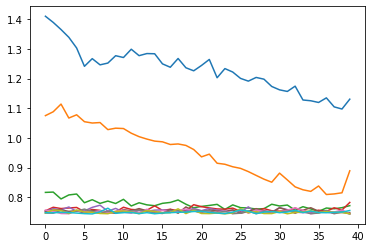

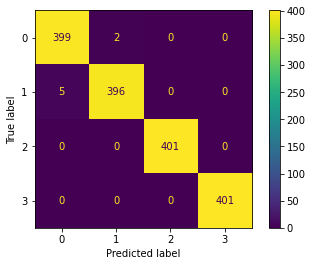

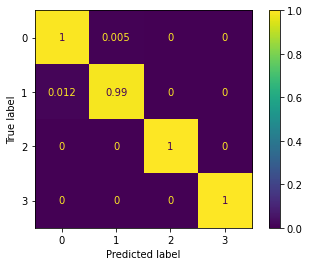

In [14]:
# training loop
for epoch in range(10):  # loop over the dataset multiple times
    loss_values=train(train_dataloader, optimizer, criterion, model)
    CM=split_test(test_dataloader, criterion, model)
    #CM2=test_complete(test_dataloader, optimizer, criterion, model)
print('Finished Training')
#print(CM[0])

disp = ConfusionMatrixDisplay(confusion_matrix=CM[0],display_labels=[0, 1, 2, 3])
disp.plot()
plt.show()
disp = ConfusionMatrixDisplay(confusion_matrix=CM[1],display_labels=[0, 1, 2, 3])
disp.plot()
plt.show()







In [15]:
#model.eval()
#for labels, inputs in manual_dataloader:
#    inputs = inputs.to(device)
#    labels = labels.to(device)
#    logging.debug(model(inputs), labels)


In [16]:
#seed = np.random.get_state()
#print(seed[1])
#df = pd.DataFrame(data = seed[1])
#df.to_csv("entladung_randomseed3.csv")

In [17]:
#torch.save(model.state_dict(), "/home/marcus/Dokumente/entladung/best_model")